In [1]:
import numpy as np
import pandas as pd
import keras
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import json
import os
import sys
import re
import subprocess
import itertools
from tqdm import tqdm
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 900147255296124452
]


### First, check inputs are in the correct format and establish a simple architecture 

Format data to only have top 25% and bottom 25% of overall data

In [3]:
# ROOT_DIR - root directory
ROOT_DIR = os.getcwd()+'/'

# FEATURE_DIR - directory where feature dataframes are saved
DATA_DIR = ROOT_DIR + 'Protein_ML/dataframes/'

In [4]:
data_codon = pd.read_csv('DF_all_w_codon_counts.csv', index_col=0)
data_codon.head()

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len,true_nt_seq,AAA,AAT,AAC,...,GTC,GTG,GCA,GCT,GCC,GCG,GGA,GGT,GGC,GGG
0,140095,G3V3N0,4.3075,IMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASS...,GACAAGCTTGCGGCCGCAATTATGACAGCTCCCTCCAGTTTTGAGC...,139,ATTATGACAGCTCCCTCCAGTTTTGAGCAGTTTAAAGTGGCAATGA...,8,6,3,...,0,4,3,4,1,1,1,1,3,2
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144,ACCTACTATGCCTGGAAGCATGAGCTGCTGGGCTCTGGCACCTGCC...,1,2,2,...,1,3,4,4,6,3,1,1,5,5
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136,TCACTCCATGCCAGACCCCCACAGTTTACGAGGGCTCAGTGGTTTG...,1,7,8,...,0,2,5,2,2,1,1,2,1,0
3,140235,H0YH02,6.7224,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,GACAAGCTTGCGGCCGCAGCGAGAGCATTAAATGAAAGCAAAAGAG...,123,GCGAGAGCATTAAATGAAAGCAAAAGAGTTAATAATGGCAACACGG...,5,7,5,...,2,5,1,5,4,2,3,0,3,1
4,140309,F5GYC5,3.3848,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,GACAAGCTTGCGGCCGCACATCGGAAAGAGCCTGGGGCAAGGCTGG...,124,CATCGGAAAGAGCCTGGGGCAAGGCTGGAGGCCACAAGAGGAGCTG...,4,1,1,...,0,1,2,3,4,1,3,2,1,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ad437633240>]],
      dtype=object)

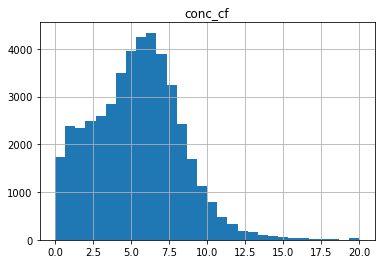

In [5]:
data_codon.hist(column='conc_cf',bins=30)

In [6]:
data_codon.conc_cf.mean()

5.4001973645199906

In [7]:
target = 'expressed'
data_codon.loc[:,target] = data_codon.conc_cf > data_codon.conc_cf.mean()
data_codon.head()

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len,true_nt_seq,AAA,AAT,AAC,...,GTG,GCA,GCT,GCC,GCG,GGA,GGT,GGC,GGG,expressed
0,140095,G3V3N0,4.3075,IMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASS...,GACAAGCTTGCGGCCGCAATTATGACAGCTCCCTCCAGTTTTGAGC...,139,ATTATGACAGCTCCCTCCAGTTTTGAGCAGTTTAAAGTGGCAATGA...,8,6,3,...,4,3,4,1,1,1,1,3,2,False
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144,ACCTACTATGCCTGGAAGCATGAGCTGCTGGGCTCTGGCACCTGCC...,1,2,2,...,3,4,4,6,3,1,1,5,5,False
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136,TCACTCCATGCCAGACCCCCACAGTTTACGAGGGCTCAGTGGTTTG...,1,7,8,...,2,5,2,2,1,1,2,1,0,False
3,140235,H0YH02,6.7224,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,GACAAGCTTGCGGCCGCAGCGAGAGCATTAAATGAAAGCAAAAGAG...,123,GCGAGAGCATTAAATGAAAGCAAAAGAGTTAATAATGGCAACACGG...,5,7,5,...,5,1,5,4,2,3,0,3,1,True
4,140309,F5GYC5,3.3848,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,GACAAGCTTGCGGCCGCACATCGGAAAGAGCCTGGGGCAAGGCTGG...,124,CATCGGAAAGAGCCTGGGGCAAGGCTGGAGGCCACAAGAGGAGCTG...,4,1,1,...,1,2,3,4,1,3,2,1,3,False


In [8]:
min_expressed = np.percentile(data_codon['conc_cf'],75)
max_not_expressed = np.percentile(data_codon['conc_cf'],25)

data_cfilt = data_codon[(data_codon['conc_cf'] > min_expressed) | (data_codon['conc_cf'] < max_not_expressed)]

print('Number expressed:',len(data_cfilt[data_cfilt[target]]))
print('Number not expressed:',len(data_cfilt[data_cfilt[target]==False]))
print('Min expression cutoff:',min_expressed)
print('Max non-expression:',max_not_expressed)

Number expressed: 11301
Number not expressed: 11302
Min expression cutoff: 7.2576
Max non-expression: 3.269225


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ad434779828>]],
      dtype=object)

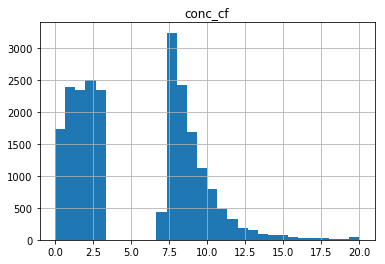

In [9]:
data_cfilt.hist(column='conc_cf',bins=30)

Now, Apply color encoding to filtered dataset 

In [10]:
len(data_cfilt.columns[7:71])

64

In [11]:
# first... let's get the list of codons from our pals Sastry et al
codon_list = data_cfilt.columns[7:71]
codon_list

Index(['AAA', 'AAT', 'AAC', 'AAG', 'ATA', 'ATT', 'ATC', 'ATG', 'ACA', 'ACT',
       'ACC', 'ACG', 'AGA', 'AGT', 'AGC', 'AGG', 'TAA', 'TAT', 'TAC', 'TAG',
       'TTA', 'TTT', 'TTC', 'TTG', 'TCA', 'TCT', 'TCC', 'TCG', 'TGA', 'TGT',
       'TGC', 'TGG', 'CAA', 'CAT', 'CAC', 'CAG', 'CTA', 'CTT', 'CTC', 'CTG',
       'CCA', 'CCT', 'CCC', 'CCG', 'CGA', 'CGT', 'CGC', 'CGG', 'GAA', 'GAT',
       'GAC', 'GAG', 'GTA', 'GTT', 'GTC', 'GTG', 'GCA', 'GCT', 'GCC', 'GCG',
       'GGA', 'GGT', 'GGC', 'GGG'],
      dtype='object')

In [12]:
def nt_seq_to_list(nt_sequence):
    return np.array(list(map(''.join, zip(*[iter(str(nt_sequence))]*3))))

data_cfilt['codon_array'] = data_cfilt.loc[:,'true_nt_seq'].apply(nt_seq_to_list)
#data_cfilt.head()

/sw/anaconda-4.3.1/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# filtering out the sequences with codon fragments
weird_seq_len = []
for idx, row in data_cfilt.iterrows():
    if len(str(row['true_nt_seq']))%3:
        weird_seq_len.append(idx)

#data.drop(weird_seq_len, inplace=True)
weird_seq_len

[]

In [14]:
with open('codon_colors.json', 'r') as fp:
    codon_colors = json.load(fp)

In [15]:
len(codon_colors)

64

In [16]:
def list_to_color_matrix(codon_array):
    # mark for garbage if codon_array is nan
    if str(codon_array[0]) == 'nan':
        return

    # otherwise return color matrix
    color_matrix = np.ndarray(shape=(len(codon_array), 4))
    for idx, codon in enumerate(codon_array):
        color_matrix[idx] = np.array(codon_colors[codon])
        
    return color_matrix

data_cfilt['color_matrix'] = data_cfilt['codon_array'].apply(list_to_color_matrix)

/sw/anaconda-4.3.1/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
data_cfilt.head()
#data_cfilt.loc[1,'color_matrix']

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len,true_nt_seq,AAA,AAT,AAC,...,GCT,GCC,GCG,GGA,GGT,GGC,GGG,expressed,codon_array,color_matrix
1,140099,G3V537,2.91540,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144,ACCTACTATGCCTGGAAGCATGAGCTGCTGGGCTCTGGCACCTGCC...,1,2,2,...,4,6,3,1,1,5,5,False,"[ACC, TAC, TAT, GCC, TGG, AAG, CAT, GAG, CTG, ...","[[0.013574272678167909, 0.4886114754109594, 0...."
2,140225,P12724,1.48770,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136,TCACTCCATGCCAGACCCCCACAGTTTACGAGGGCTCAGTGGTTTG...,1,7,8,...,2,2,1,1,2,1,0,False,"[TCA, CTC, CAT, GCC, AGA, CCC, CCA, CAG, TTT, ...","[[0.5532275834715675, 0.8806392137305686, 0.98..."
5,140325,O43506,1.50290,FVGWWTHQRFVELVVVVDNIRYLFSQSNATTVQHEVFNVVNIVDSF...,GACAAGCTTGCGGCCGCATTTGTGGGCTGGTGGACCCATCAGCGGT...,137,TTTGTGGGCTGGTGGACCCATCAGCGGTTTGTTGAGCTGGTAGTGG...,2,10,3,...,0,1,1,4,1,3,0,False,"[TTT, GTG, GGC, TGG, TGG, ACC, CAT, CAG, CGG, ...","[[0.017356812254592402, 0.617596870329498, 0.8..."
8,140354,O95072,0.92003,RRRLLFWDKETQISPEKFQEQLQTRAHCWECPMVQPPERTIRGPAE...,GACAAGCTTGCGGCCGCACGTCGCCGGTTACTGTTCTGGGACAAGG...,134,CGTCGCCGGTTACTGTTCTGGGACAAGGAGACTCAGATCTCCCCGG...,2,0,0,...,2,5,2,0,1,3,0,False,"[CGT, CGC, CGG, TTA, CTG, TTC, TGG, GAC, AAG, ...","[[0.4166338148414295, 0.7446047830557105, 0.77..."
10,140500,C9J919,2.21830,MQQPPPQKVRINLQQQPPPLQIKSVPLPTLKMQTTLVPPTVESSPE...,GACAAGCTTGCGGCCGCAATGCAACAGCCTCCACCTCAGAAAGTTC...,140,ATGCAACAGCCTCCACCTCAGAAAGTTCGAATCAATTTACAGCAAC...,2,3,3,...,0,3,1,0,1,1,1,False,"[ATG, CAA, CAG, CCT, CCA, CCT, CAG, AAA, GTT, ...","[[0.12671680502352456, 0.1954819418675614, 0.7..."


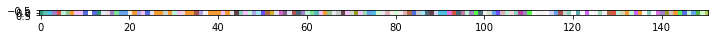

In [18]:
# show sequence barcode (chose row 45000 since it's short and the visualization is better)
barcode = data_cfilt['color_matrix'][1].reshape(1, len(data_cfilt['color_matrix'][1]), 4)

plt.figure(figsize=(12, 8))
plt.imshow(barcode, interpolation='nearest')
plt.show()